In [7]:
# Cell 1: Imports & Paths
import os, glob
import numpy as np
from math import acos
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Adjust to your landmarks folder:
NPY_ROOT = r'D:/Projects/asl_landmarks/train'


In [8]:
# Cell 2: Basic Helpers
def dist(a, b):
    return np.linalg.norm(a - b)

def angle(a, b, c):
    v1, v2 = a - b, c - b
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return acos(np.clip(cosang, -1.0, 1.0))

def normalize(coords):
    center = coords[0]
    scaled = coords - center
    ref = dist(center, coords[12]) or 1e-6
    return scaled / ref


In [9]:
# Cell 3 (updated): Feature Computation with auto-reshape

FINGERS = [
    [0,1,2,3,4],
    [0,5,6,7,8],
    [0,9,10,11,12],
    [0,13,14,15,16],
    [0,17,18,19,20],
]

def compute_features(raw_coords):
    # If flat 63-vector, reshape to (21,3)
    coords = raw_coords
    if coords.ndim == 1:
        if coords.size == 63:
            coords = coords.reshape((21, 3))
        else:
            raise ValueError(f"Unexpected landmark size: {coords.shape}")
    
    # 1) normalize (center + scale)
    center = coords[0]
    centered = coords - center
    ref = dist(center, coords[12]) or 1e-6
    norm = centered / ref

    # 2) flat coords
    flat = norm.flatten()

    # 3) bone lengths
    lengths = [ dist(norm[i], norm[j]) 
                for f in FINGERS for i,j in zip(f, f[1:]) ]
    lengths += [
        dist(norm[1], norm[17]),   # thumb_CMC→pinky_CMC
        dist(norm[0], norm[12])    # wrist→middle_tip
    ]

    # 4) joint angles
    angles = [ angle(norm[a], norm[b], norm[c]) 
               for f in FINGERS for a,b,c in zip(f, f[1:], f[2:]) ]
    
    # 5) depth variance
    depth_var = np.var(norm[:,2])

    return np.hstack((flat, lengths, angles, depth_var))
    


In [6]:
# Cell 4: Load & Split Data
classes = sorted(d for d in os.listdir(NPY_ROOT)
                 if os.path.isdir(os.path.join(NPY_ROOT, d)))
label_map = {c:i for i,c in enumerate(classes)}

X, y = [], []
for c in classes:
    folder = os.path.join(NPY_ROOT, c)
    for fp in glob.glob(os.path.join(folder, '*.npy')):
        lm = np.load(fp)
        X.append(compute_features(lm))
        y.append(label_map[c])

X = np.array(X, dtype='float32')
y = tf.keras.utils.to_categorical(y, num_classes=len(classes))

X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_trval, y_trval, test_size=0.176, stratify=y_trval, random_state=42)

print("Shapes → Train:", X_train.shape,
      "Val:", X_val.shape, "Test:", X_test.shape)


Shapes → Train: (49618, 101) Val: (10599, 101) Test: (10627, 101)


In [8]:
# Cell 5: Build & Train MLP (fixed Input layer)
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),   # <-- note the comma
    layers.Dense(150, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(75, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(len(classes), activation='softmax'),
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=[es]
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.4f}")


Epoch 1/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5274 - loss: 1.6672 - val_accuracy: 0.8934 - val_loss: 0.4193
Epoch 2/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8560 - loss: 0.5037 - val_accuracy: 0.9370 - val_loss: 0.2857
Epoch 3/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9013 - loss: 0.3731 - val_accuracy: 0.9521 - val_loss: 0.2440
Epoch 4/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9150 - loss: 0.3269 - val_accuracy: 0.9558 - val_loss: 0.2175
Epoch 5/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9238 - loss: 0.3045 - val_accuracy: 0.9588 - val_loss: 0.2035
Epoch 6/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9321 - loss: 0.2753 - val_accuracy: 0.9663 - val_loss: 0.1790
Epoch 7/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9383 - loss: 0.2625 - val_accuracy: 0.9687 - val_loss: 0.1725
Epoch 8/150
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9402 - loss: 0

In [9]:
# Cell 6: Evaluate
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {acc:.4f}")


Test accuracy: 0.9797


In [10]:
# After test evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Get raw predictions
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Per-class metrics
print("\nClassification report:\n",
      classification_report(y_true, y_pred, target_names=classes))


333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Confusion matrix:
 [[ 46   0   0 ...   0   0   0]
 [  0  80   0 ...   0   0   0]
 [  0   0  51 ...   0   0   0]
 ...
 [  0   0   0 ... 352   0   1]
 [  0   0   0 ...   0 417   0]
 [  0   0   2 ...   0   0 380]]

Classification report:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        48
           1       1.00      1.00      1.00        80
           2       0.94      0.75      0.84        68
           3       0.96      1.00      0.98        79
           4       0.88      0.99      0.93        76
           5       0.98      1.00      0.99        84
           6       0.98      0.80      0.88        65
           7       0.96      0.97      0.97        75
           8       0.95      0.86      0.90        65
           9       0.99      0.96      0.97        77
           A       0.98      0.98      0.98       358
           B       0.99      0.99      0.99       362
           C      

333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


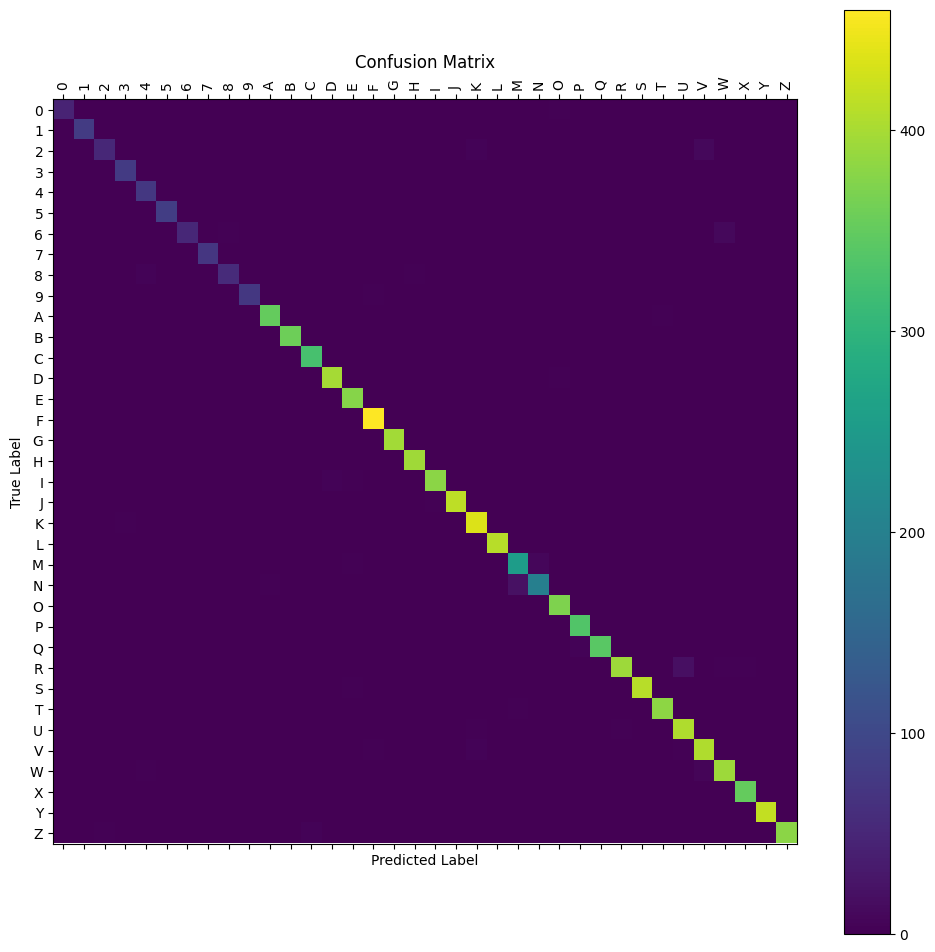

In [11]:
# Cell: Plot Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recompute predictions on X_test
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(cm)  # default colormap
fig.colorbar(cax)
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=90)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()


In [13]:
model.save('models/asl_mlp_final.keras')
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('models/asl_mlp_final.tflite', 'wb') as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpe8y_iqpv\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmpe8y_iqpv\assets


Saved artifact at 'C:\Users\lenovo\AppData\Local\Temp\tmpe8y_iqpv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 101), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  2604460811888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2604460811008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2604460813824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2604460813472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2604460869056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2604460868880: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Cell: Robust Real-Time Inference Loop

import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model

model = load_model('models/asl_mlp_final.keras')
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

cap = cv2.VideoCapture(0)
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = hands.process(rgb)

        if res.multi_hand_landmarks:
            lm3d = np.array([[p.x,p.y,p.z] 
                             for p in res.multi_hand_landmarks[0].landmark],
                            dtype=np.float32)
            feats = compute_features(lm3d).reshape(1, -1)
            preds = model.predict(feats, verbose=0)
            idx = np.argmax(preds)
            conf = preds[0, idx]
            label = classes[idx]
            cv2.putText(frame,
                        f'{label} ({conf:.2f})',
                        (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0,255,0), 2)

        cv2.imshow('ASL Recognition', frame)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q') or key == 27:  # 'q' or ESC
            break

except KeyboardInterrupt:
    # In case you hit Ctrl+C in the notebook
    pass

finally:
    hands.close()
    cap.release()
    cv2.destroyAllWindows()


In [2]:
# Cell: TFLite Interpreter Inference (Python)

import numpy as np
import cv2
import mediapipe as mp
import tensorflow as tf

# 1) Load your tflite model
interpreter = tf.lite.Interpreter(model_path="models/asl_mlp_final.tflite")
interpreter.allocate_tensors()

# 2) Get input/output tensor details
input_details  = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 3) Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

# 4) Start webcam loop
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret: break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = hands.process(rgb)

    if res.multi_hand_landmarks:
        lm3d = np.array([[p.x,p.y,p.z] 
                         for p in res.multi_hand_landmarks[0].landmark],
                        dtype=np.float32)
        # compute_features must match your training pipeline
        feats = compute_features(lm3d).astype(np.float32).reshape(1, -1)

        # 5) Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], feats)

        # 6) Run inference
        interpreter.invoke()

        # 7) Get the output
        preds = interpreter.get_tensor(output_details[0]['index'])
        idx  = np.argmax(preds[0])
        conf = preds[0, idx]
        label = classes[idx]

        cv2.putText(frame,
                    f"{label} ({conf:.2f})",
                    (10,30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)

    cv2.imshow("TFLite ASL", frame)
    if cv2.waitKey(1) & 0xFF in (ord('q'), 27):
        break

hands.close()
cap.release()
cv2.destroyAllWindows()


D:\Projects\signify-ml\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


NameError: name 'dist' is not defined

In [15]:
# Unified TFLite Inference (Image & Webcam) for Jupyter Lab

import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from math import acos

# --- Helpers -----------------------------------------------------------------

def dist(a, b):
    return np.linalg.norm(a - b)

def angle(a, b, c):
    v1 = a - b
    v2 = c - b
    cosang = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    return acos(np.clip(cosang, -1.0, 1.0))

FINGERS = [
    [0,1,2,3,4],
    [0,5,6,7,8],
    [0,9,10,11,12],
    [0,13,14,15,16],
    [0,17,18,19,20],
]

def compute_features(raw):
    coords = raw.reshape((21,3)) if raw.ndim==1 else raw.copy()
    # normalize around wrist
    wrist = coords[0]
    ref = dist(wrist, coords[12]) or 1e-6
    coords = (coords - wrist) / ref
    
    feats = []
    # flattened coords
    feats.extend(coords.flatten())
    # bone lengths
    for finger in FINGERS:
        for i,j in zip(finger, finger[1:]):
            feats.append(dist(coords[i], coords[j]))
    # palm & hand lengths
    feats.append(dist(coords[1], coords[17]))
    feats.append(dist(coords[0], coords[12]))
    # joint angles
    for finger in FINGERS:
        for a,b,c in zip(finger, finger[1:], finger[2:]):
            feats.append(angle(coords[a], coords[b], coords[c]))
    # depth variance
    feats.append(np.var(coords[:,2]))
    
    return np.array(feats, dtype=np.float32).reshape(1, -1)

# --- Load TFLite Model -------------------------------------------------------

interpreter = tf.lite.Interpreter(model_path="models/asl_mlp_final.tflite")
interpreter.allocate_tensors()
input_det  = interpreter.get_input_details()[0]
output_det = interpreter.get_output_details()[0]

# class labels
classes = [str(i) for i in range(10)] + [chr(ord('A')+i) for i in range(26)]

# --- MediaPipe Setup --------------------------------------------------------

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                       min_detection_confidence=0.5)

# --- Single-Image Inference -------------------------------------------------


# --- Real-Time Webcam Inference ---------------------------------------------

def infer_webcam():
    cap = cv2.VideoCapture(0)
    try:
        while True:
            ret, frame = cap.read()
            if not ret: break
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            res = hands.process(rgb)
            if res.multi_hand_landmarks:
                lm3d = np.array([[p.x,p.y,p.z] 
                                 for p in res.multi_hand_landmarks[0].landmark],
                                dtype=np.float32)
                feats = compute_features(lm3d)
                interpreter.set_tensor(input_det['index'], feats)
                interpreter.invoke()
                probs = interpreter.get_tensor(output_det['index'])[0]
                idx = np.argmax(probs)
                label, conf = classes[idx], probs[idx]
                cv2.putText(frame, f"{label}({conf:.2f})", (10,30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
            cv2.imshow("ASL TFLite Test", frame)
            if cv2.waitKey(1) & 0xFF in (ord('q'), 27):
                break
    finally:
        hands.close()
        cap.release()
        cv2.destroyAllWindows()

# Usage:
# infer_image("path/to/your/test.jpg")
# infer_webcam()
